[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/drnet_nlp_dataset_after_minus_log_fix_CONVERGE.ipynb)

In [30]:
#!pip install spacy   #can take few minutes
#!python -m spacy download en
#!pip install git+https://github.com/fastai/fastai.git
!pip install torch -U # 0.4 at-least

!pip install torchtext  # for simpler datasets

!pip install git+https://github.com/IBM/pytorch-seq2seq  #for seq2seq
#!pip install git+https://github.com/shahsohil/stableGAN  # for AdamPre adv optimizer
!pip install dill  #req of seq2seq
!pip install tqdm  #req of seq2seq

#!pip install revtok

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (0.4.1)
  Cloning https://github.com/IBM/pytorch-seq2seq to /tmp/pip-req-build-6z27d1ob
  Running setup.py bdist_wheel for seq2seq ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-5hnk9872/wheels/98/b5/06/771c406b3ecc8ed34f07da72d7baf65b87e561bd9f808e91bd
Successfully built seq2seq


In [0]:
#copied VERBATIM from  git+https://github.com/shahsohil/stableGAN (lacks setup.py)

import math
from torch.optim.optimizer import Optimizer


class AdamPre(Optimizer):
    """Implements Adam algorithm with prediction step.
    This class implements lookahead version of Adam Optimizer.
    The structure of class is similar to Adam class in Pytorch.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, name='NotGiven'):
        self.name = name
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(AdamPre, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                    state['oldWeights'] = p.data.clone()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** min(state['step'],1022)
                bias_correction2 = 1 - beta2 ** min(state['step'],1022)
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)
        return loss

    def stepLookAhead(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                temp_grad = p.data.sub(state['oldWeights'])
                state['oldWeights'].copy_(p.data)
                p.data.add_(temp_grad)
        return loss


    def restoreStepLookAhead(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                p.data.copy_(state['oldWeights'])
        return loss

# Dataset with torchtext

In [32]:

import random

import time
import numpy as np
from collections import namedtuple
import logging
import torch
from torch.utils.data import Dataset, DataLoader
import torchtext.data as data
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

random.seed(42)

# on sample of the dataset
TimeExample = namedtuple('TimeExample',['src','sent_0','sent_1','sent_x','is_x_0','sent_0_target'])

class TimeStyleDataset(Dataset):
  
  def __init__(self,max_id,time_mod_3_result,label_smoothing=False): 
    """
    max_id how many samples are in this dataset. Size of one epoc!
    time_mod_3_result - to make sure time is train/test/valid is different, pass 0,1,2
    label_smoothing - trick from "soumith/ganhacks", instead of 0/1 labels, pass 0-0.3, 0.7-1.2 labels
    """
    self.max_id =int(max_id)
    #TODO : add more!!# see here: https://docs.python.org/2/library/datetime.html month can be: %b,%B,%m , year: %y,%Y
    self.formats = ["%b %d %Y %H:%M:%S", "%m/%d/%Y %H:%M:%S", "%d-%b-%Y %H.%M.%S.00",
                    "%B %d %y %H:%M:%S" ,"%B %d %H:%M:%S %Y", "%d/%B/%Y %H:%M:%S"]
    self.time_mod_3_result=time_mod_3_result
    self.label_smoothing = label_smoothing 
  
  def __len__(self):
    return self.max_id
  
  def _tvt(self,idx):
    # for 10, if train, return 9, valid 10, test 11
    return (idx//3) * 3 + self.time_mod_3_result #10//3 * 3 + x = 9+x
  
  def __getitem__(self,idx):
    if idx > self.max_id:
      raise IndexError(f'TimeStyleDataset {idx} is out of range {self.max_id}')
    
    """ x -  x[0] semantic0   , style0
             x[1] semantic0   , style1   
             x[2] semantic0orX, style0 (1/2 the time 0 , half X)
    """
    max_time= 2*int(2e9)  #means 1970-2001
    
    random_ids = np.random.randint(low=0,high=max_time,size=2)
    idx = random_ids[0] #other_idx is 50% same, 50% other
    other_idx = random_ids[1] if np.random.randint(0,2)==0 else random_ids[0]

    idx = self._tvt(idx)
    other_idx = self._tvt(other_idx)
   
    # two random formats
    random_fs= np.random.choice(len(self.formats),size=2,replace=False)
    
    sent_0= time.strftime(self.formats[random_fs[0]],time.gmtime(idx)) 
    sent_1= time.strftime(self.formats[random_fs[1]],time.gmtime(idx)) 
    sent_x= time.strftime(self.formats[random_fs[0]],time.gmtime(other_idx))
    y = torch.FloatTensor(np.array([idx==other_idx],np.float32))
    if self.label_smoothing:
      y[y==1.0] = (0.7+0.5* np.random.rand()) 
      y[y==0.0] = (0.3 * np.random.rand())

    return TimeExample(sent_0,sent_0,sent_1,sent_x,y,sent_0)

def test():
  dataset = TimeStyleDataset(1e3,1)
  for i in range(3):
    sample = dataset[i] ; print ('test sample',sample)  
  #print ('len',len(dataset))
  
test()


def revers_vocab(vocab,sent,seperator):
  return seperator.join([vocab.itos[token] for token in sent])




from seq2seq.dataset import SourceField,TargetField
"""" Wrapper class of torchtext.data.Field that forces batch_first to be True 
and prepend <sos> and append <eos> to sequences in preprocessing step. """
TEXT_TARGET = TargetField(batch_first =True,sequential=True,use_vocab=True, lower=False, init_token=TargetField.SYM_SOS,
                 eos_token=TargetField.SYM_EOS, tokenize=lambda x: list(x)) # fix_length=10
TEXT = SourceField(batch_first =True,sequential=True,use_vocab=True, lower=False,
                            tokenize=lambda x: list(x)) # fix_length=10
LABEL= data.Field(batch_first=True,sequential=False,use_vocab=False, tensor_type =torch.FloatTensor)


fields = [('src',TEXT),('sent_0',TEXT),('sent_1',TEXT),('sent_x',TEXT),('is_x_0',LABEL),('sent_0_target',TEXT_TARGET)] 
ds_train = data.Dataset(TimeStyleDataset(1e3,1,label_smoothing=True), fields)
ds_eval = data.Dataset(TimeStyleDataset(1e3,2), fields)

print ('printing dataset directly, before tokenizing:')
print ('sent_0',ds_train[2].sent_0) #not processed
print ('is_x_0',ds_train[2].is_x_0) #not processed

print ('\nbuilding vocab:')
#TEXT.build_vocab(ds, max_size=80000)
TEXT_TARGET.build_vocab(ds_train, max_size=80000)
TEXT.vocab = TEXT_TARGET.vocab #same except from the added <sos>,<eos>

print ('vocab TEXT: len',len(TEXT.vocab), 'common',TEXT.vocab.freqs.most_common()[:10])
print ('vocab TEXT_TARGET:',len(TEXT_TARGET.vocab), TEXT_TARGET.vocab.freqs.most_common()[:10])
print ('vocab ',TEXT_TARGET.SYM_SOS, TEXT_TARGET.sos_id,TEXT_TARGET.vocab.stoi[TEXT_TARGET.SYM_SOS])
print ('vocab ',TEXT_TARGET.SYM_EOS, TEXT_TARGET.eos_id,TEXT_TARGET.vocab.stoi[TEXT_TARGET.SYM_EOS])
print ('vocab ','out-of-vocab', TEXT_TARGET.eos_id,TEXT_TARGET.vocab.stoi['out-of-vocab'])

       
device = None if torch.cuda.is_available() else -1
# READ:  https://github.com/mjc92/TorchTextTutorial/blob/master/01.%20Getting%20started.ipynb
sort_within_batch=True
train_iter = iter(data.BucketIterator( dataset=ds_train, device=device,batch_size=32, sort_within_batch=sort_within_batch,sort_key=lambda x: len(x.sent_0))) 
eval_iter =  iter(data.BucketIterator( dataset=ds_eval, device=device, batch_size=32, sort_within_batch=sort_within_batch,sort_key=lambda x: len(x.sent_0))) 
#performance note: the first next, takes 3.5s, the next are fast (10000 is 1s)


for i in range(1):
  b= next(train_iter)
  # usage
  print ('\nb.is_x_0',b.is_x_0[0],b.is_x_0.type())
  print ('b.src is values+len tuple',b.src[0].shape,b.src[1].shape )
  print ('b.sent_0_target',b.sent_0_target.shape,b.sent_0_target[0],revers_vocab(TEXT_TARGET.vocab,b.sent_0_target[0],''))
  print ('b_sent0',b.sent_0[0].shape,b.sent_0[1].shape,b.sent_0[0][0],revers_vocab(TEXT.vocab,b.sent_0[0][0],''))
  print ('b_sent1',b.sent_1[0].shape,b.sent_1[1].shape,b.sent_1[0][0],revers_vocab(TEXT.vocab,b.sent_1[0][0],''))
  print ('b_sentx',b.sent_x[0].shape,b.sent_x[1].shape,b.sent_x[0][0],revers_vocab(TEXT.vocab,b.sent_x[0][0],''))
  print ('b_y',b.is_x_0.shape,b.is_x_0)
  print (b.sent_0[1])




test sample TimeExample(src='03/30/2084 00:21:07', sent_0='03/30/2084 00:21:07', sent_1='March 30 84 00:21:07', sent_x='06/01/2013 08:11:28', is_x_0=tensor([0.]), sent_0_target='03/30/2084 00:21:07')
test sample TimeExample(src='11/04/2066 20:07:01', sent_0='11/04/2066 20:07:01', sent_1='04/November/2066 20:07:01', sent_x='05/06/2049 17:43:55', is_x_0=tensor([0.]), sent_0_target='11/04/2066 20:07:01')
test sample TimeExample(src='December 15 89 00:04:34', sent_0='December 15 89 00:04:34', sent_1='15-Dec-2089 00.04.34.00', sent_x='November 18 79 12:28:46', is_x_0=tensor([0.]), sent_0_target='December 15 89 00:04:34')
printing dataset directly, before tokenizing:
sent_0 28-Feb-2084 21.11.34.00
is_x_0 tensor([0.0994])

building vocab:
vocab TEXT: len 45 common [('0', 2818), ('2', 2049), (' ', 1989), ('1', 1970), (':', 1636), ('3', 977), ('4', 959), ('5', 879), ('9', 831), ('/', 648)]
vocab TEXT_TARGET: 45 [('0', 2818), ('2', 2049), (' ', 1989), ('1', 1970), (':', 1636), ('3', 977), ('4', 

In [33]:
y= np.array([1,1,1])
print (y.shape,y)

y[y==0.0] = (0.3*np.random.rand(*y.shape))[y==0.0]
print (y)



(3,) [1 1 1]
[1 1 1]


# models define

## Documentation

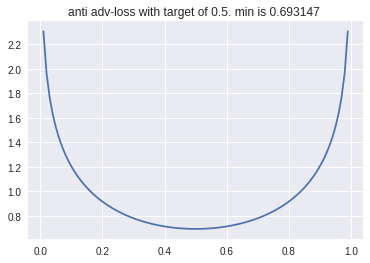

In [34]:
import numpy as np


# semantic_encoder : take sentence return a vector with only semantics
# semantic similiary objective: given a pair of sentences with the same semantics,
#    expect their results to be close (MeanSquared)    

# see idea from https://github.com/edenton/drnet-py/blob/master/models/classifiers.py
# in her train method:
# FRAMES: VID A: FRAME 1 x_c1 , ?x_p2? (1/2 of times)
#                FRAME 2 x_c2 , x_p1
#         VID B: FRAME 1      , ?x_p2? (1/2 of times)
#  
# x_p1,x_p2 chosen randonly from same/not-same video
# x_c1,x_c2 are always same-video
# c1 and p1 are same content, different pose.

# train_scene_discriminator()
# h_p1,h_p2 = netEP applied to x[0],x[1]. assumption: SAME VIDEO
# important: detach both!
# override half of h_p2 by random-permutations of the batch. 
#   [1,2,3,4,5,6]
#   [2,3,1,4,5,6] after 1st half permute
#   [1,1,1,0,0,0] set unequal the labels (1=unequal, 0 equal. does it matter? should it be 0.9,0.1?)
# apply BCE on inpit: concat of [h_p1,h_p2] 
# run backward, and optimizer on the netC classifier ONLY! emphasize! not on the encoder


# train()
# h_c1,h_c2 = netEC(x_c1), netEC(x_c2)  where input is x[0],x[1] sim loss is MSE directly on the hidden content-semantics
# h_p1,h_p2 = netEP(x_p1),netEP(x_p2) where input is x[2],x[3]
# rec = netD([h_c1, h_p1]) h_c1 is DIFFERENT FRAME , but same content, than h_p1
# netC is the semantic-discriminator given h_p1,h_p2, target 0.5 (max-entropy). 
# emphasize! don't optimize netC is this stage

#Imp notes
# BIDI: when using bidi-encoder, we decided to merge the two D-dim vectors using +, getting D-dim embedding. empiracally, better result than concat
# OPTIMIZER: adv training is known to be unstable. We used the following known methods to make it more stable:
#            ??? sensativity to lr (fail to converge on close lr)- use AdamPre optimizer instead of Adam
#            ??? don't use ReLU layer, use Leaky instead (I used PreRELU)
#            never allow G or D to achieve high accuracy (before the end)  
#            IMPORTANT: noisy input via dropout
#            IMPORTANT: label_smoothing on the ds
# ANTI-ADVERSERTIAL LOSS FUNCTION, target is 0.5, so min value is 0.6931471805599453
%matplotlib inline
import matplotlib.pyplot as plt
x = np.arange(1,100)/100.0
plt.title("anti adv-loss with target of 0.5. min is 0.693147 ")
plt.plot(x, -0.5*(np.log(x)+np.log(1-x)))
#-0.5*(np.log(0.53)+np.log(1-0.53))



## PARAMS

In [35]:
import argparse
import sys
parser = argparse.ArgumentParser()

parser.add_argument('--epocs', type=int, default=2, help='number of epochs to train for')
parser.add_argument('--epoch_size', type=int, default=600, help='epoch size')
parser.add_argument('--batch_size', default=32, type=int, help='batch size')

parser.add_argument('--optimizer', default='adampre', help='optimizer to train with. only Adam, AdamPre supported. Without AdamPre you must pinpoint the right learning-rate, otherwise training will not converge.')
parser.add_argument('--lr', default=0.0025, type=float, help='learning rate. source=0.002')
parser.add_argument('--adv_disc_lr', default=0.01, type=float, help='learning rate')

parser.add_argument('--beta1', default=0.5, type=float, help='momentum term for adam')

parser.add_argument('--semantics_dim', type=int, default=200, help='size of the semantics vector')
parser.add_argument('--style_dim', type=int, default=60, help='size of the style vector')
parser.add_argument('--sd_weight', type=float, default=0.05, help='weight on adversarial loss 0.0001 originally. 0.5 is good value!')
parser.add_argument('--sem_sim_weight', type=float, default=100, help='weight on semantic similiarity loss')

parser.add_argument('--max_sent_len', type=int, default=40, help='max size of sentence. sentences typically will be shorter')


'''
parser.add_argument('--max_step', type=int, default=20, help='maximum distance between frames')
parser.add_argument('--seed', default=1, type=int, help='manual seed')
parser.add_argument('--log_dir', default='logs', help='base directory to save logs')
parser.add_argument('--data_root', default='', help='root directory for data')

parser.add_argument('--dataset', default='moving_mnist', help='dataset to train with')

parser.add_argument('--sd_nf', type=int, default=100, help='number of layers')
parser.add_argument('--content_model', default='dcgan_unet', help='model type (dcgan | dcgan_unet | vgg_unet)')
parser.add_argument('--pose_model', default='dcgan', help='model type (dcgan | unet | resnet)')
parser.add_argument('--data_threads', type=int, default=5, help='number of parallel data loading threads')
parser.add_argument('--data_type', default='drnet', help='speed up data loading for drnet training')
'''
sys.argv=["nothing"]
opt = parser.parse_args()
print (opt.lr,)

0.0025


In [36]:
type(np.array([2
         ]))

numpy.ndarray

# Define Encoder, Decoder

#   decoders

In [42]:
#trn_dl = DataLoader(TimePairsDataset(1e5,1), batch_size=opt.batch_size,)
#x,y = next(iter(trn_dl)) 
#print ('input . x is vertically stacked sentences',x.shape,'y',y.shape)
#batch,pair,sentence_len=x.shape


from seq2seq.models import EncoderRNN, DecoderRNN
from torch import nn


random.seed(42)

########################## UTILS ##########################
cuda=True
def T(arg):
  if cuda:
    if type(arg)==tuple:
      arg = tuple( t.cuda() for t in arg ) #new tuple all cuda-d
    else:
      arg = arg.cuda()
  return arg

def N(arg):
  if isinstance(arg,np.ndarray) or isinstance(arg,np.float64):
    return arg #as is
  # to numpy
  return arg.cpu().numpy()

########################## MODELS ##########################
class EncoderWrapper(nn.Module):
  """ wraps encoder, accpet in forward tuple of (data,len). return last hidden"""
  def __init__(self,encoder):
    super(EncoderWrapper,self).__init__()
    self.encoder = encoder
  
  def forward(self,inp):

      #in_data,in_len = in_tuple
      output,hidden = self.encoder(*inp)#in_data,in_len)
      # **output** (batch, seq_len, hidden_size): tensor containing the encoded features of the input sequence
      # **hidden** (num_layers * num_directions, batch, hidden_size): tensor containing the features in the hidden state `h`
      #return hidden[0,:,:]
      #return hidden[:,:,:].# view(1,hidden.size(1),-1)[0,:,:] #BUG BUG BUG O: check dim order, 2xbsxdim -> 1xbsxdim*2 ??
      
      #in lstm hidden is a tuple
      return torch.sum(hidden,dim=0)
      #TODO : BUG HERE 



variable_lengths = False  # True means batch is ordered. this can't be done as sent0.len!=sent1.len, to make it happen need to seperate batches!!!
encoder_bidi=True
decoder_bidi=True #not supported True
encoder_layers=1  #not supported>1
decoder_layers=1

# Arch. Question How to work with bidi and multiple layers? 
# currently, encoder combines with + (sum) bidi vectors. after 8 epocs of 100 batches(100 each) less then 1 recon_loss
# multiple layers not supported


en_sem = EncoderWrapper(EncoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.semantics_dim,variable_lengths =variable_lengths,bidirectional = encoder_bidi,n_layers=encoder_layers,
                                   input_dropout_p = 0.1 , dropout_p =0.0 , rnn_cell='gru'))
                                   
en_sty = EncoderWrapper(EncoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.style_dim, variable_lengths = variable_lengths,bidirectional = encoder_bidi,n_layers=encoder_layers,
                                   input_dropout_p = 0.1 , dropout_p =0.0,rnn_cell='gru'))

decoder = DecoderRNN(len(TEXT.vocab),opt.max_sent_len, (1 if encoder_bidi else 1)*(opt.semantics_dim + opt.style_dim),sos_id=TEXT_TARGET.sos_id,eos_id=TEXT_TARGET.eos_id,
                     bidirectional = decoder_bidi,n_layers=decoder_layers,
                     input_dropout_p = 0.1 , dropout_p =0.0,rnn_cell='gru')




      
adv_disc = nn.Sequential(
  # input concat of two style
  nn.Linear(2*opt.style_dim,30),
  nn.PReLU(),
  nn.Linear(30,20),
  nn.PReLU(),
  nn.Linear(20,1),
  nn.Sigmoid() #depends on what we have as loss #Must be sigmoid, we apply later BCE
)



en_sem = T(en_sem)
en_sty = T(en_sty)
decoder =T(decoder)
adv_disc = T(adv_disc)

def train_gen() :
  return iter(data.BucketIterator( dataset=ds_train, device=device,batch_size=32, sort_within_batch=True,sort_key=lambda x: len(x.sent_0))) 



merge_dim = 1 #1 before
def test():
  sample = next(train_gen())
  
  print (type(sample.sent_0))
  in_var,in_len=sample.sent_0

  #print ('length0',sample.sent_0[1])
  #print ('length1',sample.sent_1[1])
  sem_out = T(en_sem(sample.sent_0))
  print ('result of en_sem',sem_out.shape)   #[1, 32, 20]
  sty_out = T(en_sty(sample.sent_1))
  print ('sty_out',sty_out.shape,
        'concat',T(torch.cat([sty_out, sty_out],dim=merge_dim)).shape)
  
  merged = T(torch.cat([sty_out, sty_out],dim=merge_dim))
  print ('merged1',merged.type(),merged.shape )
  disc_out = T(adv_disc(merged))
  print (disc_out.shape)

  merged = T(torch.cat([sem_out,sty_out],dim=merge_dim))
  merged.unsqueeze_(0)
  print ('merged2',merged.shape)
  decoder_outputs, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                            encoder_hidden=merged, #(num_layers * num_directions, batch_size, hidden_size)
                            encoder_outputs = None, # pass not None for attention
                            teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                           ) 
  decoder_outputs = decoder_outputs
  #**decoder_outputs** (seq_len, batch, vocab_size): list of tensors with size (batch_size, vocab_size) containing
  #          the outputs of the decoding function.
  print ('decoder_outputs',len(decoder_outputs),decoder_outputs[0].shape)


  
  
test()

opt.optimizer= 'adam'

if opt.optimizer=='adam':
  optimizer = torch.optim.Adam
elif opt.optimizer=='adampre':
  optimizer = AdamPre

optimizer_first_time = True  #relevant only to AdamPre

optimizer_en_sem = optimizer(en_sem.parameters(), opt.lr) #(, betas=(opt.beta1, 0.999))
optimizer_en_sty = optimizer(en_sty.parameters(), opt.lr) #), betas=(opt.beta1, 0.999))
optimizer_decoder = optimizer(decoder.parameters(), opt.lr) #)opt.lr), betas=(opt.beta1, 0.999))
optimizer_adv_disc = optimizer(adv_disc.parameters(), opt.adv_disc_lr) ##), betas=(opt.beta1, 0.999))

print (optimizer)  

 

<class 'tuple'>
result of en_sem torch.Size([32, 200])
sty_out torch.Size([32, 60]) concat torch.Size([32, 120])
merged1 torch.cuda.FloatTensor torch.Size([32, 120])
torch.Size([32, 1])
merged2 torch.Size([1, 32, 260])
decoder_outputs 40 torch.Size([32, 45])
<class 'torch.optim.adam.Adam'>


# EVAL

In [43]:


def eval_sample(samples=3):
  #back to eval mode
  en_sty.eval()  # and not eval() mode
  en_sem.eval()
  decoder.eval()
  adv_disc.eval()

  eval_batch_generator = iter(data.BucketIterator( dataset=ds_eval, device=device,batch_size=32, sort_within_batch=False,sort_key=lambda x: len(x.sent_0))) 
  b = next(eval_batch_generator)
  #b = next(training_batch_generator)
  #rec loss of 0.4 means good style, half of chars correct (but half wrong)

  sent0 = T(b.sent_0)
  sent1 = T(b.sent_1)
  sentX = T(b.sent_x)
  
  recon_target = b.sent_0_target  


  h_sem0 = en_sem(sent0)
  h_sem1 = en_sem(sent1)
  h_semX = en_sem(sentX)
  
  h_sty0 = en_sty(sent0)
  h_sty1 = en_sty(sent1)
  h_styX = en_sty(sentX)
  
  recon_sem0_sty0, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                        #encoder_hidden=T(torch.cat([h_sem1,h_sty0],dim=1)).unsqueeze(0), #(num_layers * num_directions, batch_size, hidden_size)
                        encoder_hidden=T(torch.cat([h_sem0,h_sty0],dim=merge_dim)).unsqueeze(0),#(num_layers * num_directions, batch_size, hidden_size)
                        encoder_outputs = None, # pass not None for attention
                        teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                       ) 
  
  
  recon_semX_sty0, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                        #encoder_hidden=T(torch.cat([h_sem1,h_sty0],dim=1)).unsqueeze(0), #(num_layers * num_directions, batch_size, hidden_size)
                        encoder_hidden=T(torch.cat([h_semX,h_sty0],dim=merge_dim)).unsqueeze(0),#(num_layers * num_directions, batch_size, hidden_size)
                        encoder_outputs = None, # pass not None for attention
                        teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                       ) 
  
  recon_semX_sty1, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                        encoder_hidden=T(torch.cat([h_semX,h_sty1],dim=merge_dim)).unsqueeze(0), #(num_layers * num_directions, batch_size, hidden_size)
                        encoder_outputs = None, # pass not None for attention
                        teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                       ) 
  
  recon_semX_sty1_tf1, _,_ = decoder(inputs=recon_target,  # pass not None for teacher focring  (batch, seq_len, input_size)
                        encoder_hidden=T(torch.cat([h_semX,h_sty1],dim=merge_dim)).unsqueeze(0), #(num_layers * num_directions, batch_size, hidden_size)
                        encoder_outputs = None, # pass not None for attention
                        teacher_forcing_ratio=1 #range 0..1 , must pass inputs if >0
                       ) 

  for i in range(samples):
    print ('\n%20s'%'sent0:', revers_vocab(TEXT_TARGET.vocab,sent0[0][i],''))
    print ('%20s'%'sent0_targ:',revers_vocab(TEXT_TARGET.vocab,recon_target[i],''))
    print ('%20s'%'sent1:',revers_vocab(TEXT_TARGET.vocab,sent1[0][i],''))
    print ('%20s'%'sentX:',revers_vocab(TEXT_TARGET.vocab,sentX[0][i],''))

    # recon_sent is a list of : batch x softmax array
    tokens= (np.array(([N(torch.argmax(l, dim=1)[i]) for l in recon_sem0_sty0])))
    print ('%20s'%'recon_sem0_sty0:[TF=0]',revers_vocab(TEXT_TARGET.vocab,tokens,''))

    tokens= (np.array(([N(torch.argmax(l, dim=1)[i]) for l in recon_semX_sty0])))
    print ('%20s'%'recon_semX_sty0:[TF=0]',revers_vocab(TEXT_TARGET.vocab,tokens,''))

    tokens= (np.array(([N(torch.argmax(l, dim=1)[i]) for l in recon_semX_sty1])))
    print ('%20s'%'recon_semX_sty1:[TF=0]',revers_vocab(TEXT_TARGET.vocab,tokens,''))
    
    tokens= (np.array(([N(torch.argmax(l, dim=1)[i]) for l in recon_semX_sty1_tf1])))
    print ('%20s'%'recon_semX_sty1:[TF=1]',revers_vocab(TEXT_TARGET.vocab,tokens,''))
  
  en_sty.train()  # and not eval() mode
  en_sem.train()
  decoder.train()
  adv_disc.train()
    
  
  
eval_sample(1)


              sent0: 08/November/1985 09:07:41
         sent0_targ: <sos>08/November/1985 09:07:41<eos>
              sent1: 08-Nov-1985 09.07.41.00<pad><pad>
              sentX: 27/November/2079 01:27:44<pad>
recon_sem0_sty0:[TF=0] <pad>on<sos>S:p/6e/6iby<eos>AF1OAm9<eos>5<sos>--Sc:p6/e/u688
recon_semX_sty0:[TF=0] S888888888888888888888888888888888888888
recon_semX_sty1:[TF=0] S S:p6/e/u688888888888888888888888888888
recon_semX_sty1:[TF=1] S-<sos>eey8nppn<unk><sos>Ob<eos><sos>7llpp9p0<eos>


In [39]:

np.log(0.5)

-0.6931471805599453

# Train loop

In [41]:
# --------- training funtions ------------------------------------
def train(b,epoch=0):
    # x[0] semantic0   , style0
    # x[1] semantic0   , style1   
    # x[2] semantic0orX, style0 (1/2 the time 0 , half X)

    en_sty.zero_grad() 
    en_sem.zero_grad()
    decoder.zero_grad()
    
    if opt.optimizer=='adampre':
      optimizer_adv_disc.stepLookAhead()
  

    sent0 = b.sent_0
    sent1 = b.sent_1
    sentX = b.sent_x
    recon_target = b.sent_0_target  #one-hot
    
    logger.debug(f'sent0 {sent0[0].shape} {sent0[1].shape}')    

    ######### SIM LOSS #########
    h_sem0 = en_sem(sent0) 
    h_sem1 = en_sem(sent1) 

    sim_loss=0
    '''logger.debug(f'h_sem0 shape {h_sem0.shape}')
    # if you want to use torch criterion, you need to copy the label and set it to not requreing gradiant
    # so below is different than nn.MSELoss()(h_sem0,h_sem1.detach()). I wonder if only one get grad updates!
    sim_loss = torch.sum(torch.pow(h_sem0- h_sem1,2),dim=1)
    logger.debug(f'sem_loss: {h_sem0.shape} {h_sem1.shape} {sim_loss.shape} {sim_loss}')
    sim_loss = torch.mean(sim_loss)
    logger.debug(f'sem_loss: {h_sem0.shape} {h_sem1.shape} {sim_loss.shape} {sim_loss}')
    '''
    
    
    

    ######### RECONSTRUCTION LOSS #########
    # reconstruct sent0 from semantics of sent1 (==sem of sent0, different style), and style of sent0.
    h_sty0 = en_sty(sent0)
    merged= torch.cat([h_sem1,h_sty0],dim=merge_dim)
    merged.unsqueeze_(0) #32x25 -> 1x32x25 . 1 is for one hidden-layer (not-stacked)
    logger.debug(f'h_sem1.h_sty0 {h_sem1.shape} {h_sty0.shape,merged.shape}')
    
    
    recon_sent0, _,_ = decoder(inputs=recon_target,  # pass not None for teacher focring  (batch, seq_len, input_size)
                          encoder_hidden=merged, #(num_layers * num_directions, batch_size, hidden_size)
                          encoder_outputs = None, # pass not None for attention
                          teacher_forcing_ratio=1 #in(0, 1-random.random()* epoch * 0.1) #range 0..1 , must pass inputs if >0. as epochs increase, it's lower
                         ) 
    #print('$'*10,'recon_sent0 length',len(recon_sent0),'each',recon_sent0[0].shape)
    #rec_loss = nn.MSELoss()(recon_sent0,sent0)
    # see impl https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/loss/loss.py
    acc_loss, norm_term=0,0
    logger.debug(f'recon_target {recon_target.shape} while decoder outputs {len(recon_sent0)}')
    #target shape [32, 26]  batch x words , actual len of 50
    for step, step_output in enumerate(recon_sent0):
      batch_size = recon_target.size(0)
      #print('step_output at step ',step,step_output.shape,type(step_output))
      outputs = step_output #step_output.contiguous().view(batch_size, -1)
      
      # what to do if output is too-long? decision here is to match only relevant parts
      if step+1>=recon_target.size(1):  
        #print ('breaking!!! at step',step)
        break
      gold = recon_target[:, step + 1] #tuple [0] is data. [1] is len
      #print('output at step ',step,outputs.shape,type(outputs),'gold',gold.shape,type(gold))
      curr_loss = nn.NLLLoss()(outputs, gold)
      #logger.debug(f'loss for token {norm_term},{outputs.shape}, {gold.shape}, {curr_loss}')
      acc_loss += curr_loss
      norm_term += 1
    rec_loss = acc_loss/norm_term
    
    
    ######### ADV LOSS #########  TODO : willl it be better to use completely different sentences?
    h_styX = en_sty(sentX)
    adv_disc_p =  adv_disc(torch.cat([h_sty0,h_styX],dim=merge_dim))
    #logger.debug (N(adv_disc_p[0:3].data).T)
    adv_target = T(torch.FloatTensor(np.full(shape =(sent0[0].shape[0],1),fill_value=0.5)))
    # the loss below is a parabula with min at log(0.5)=0.693... see documentation above
    adv_disc_loss = nn.BCELoss()(adv_disc_p, adv_target) 
    logger.debug(f'### adv_disc_loss {N(adv_disc_p.data[:5]).T} target={N(adv_target.data[:5]).T} bce={adv_disc_loss}')
    adv_disc_loss += np.log(0.5)  #np.log(0.5)=-0.693 , 
    logger.debug(f'    sanity test: on first step, you expect adv_disc_loss to be near zero')
    
    
    ######### BACKWARD #########
    # full loss
    loss = rec_loss + sim_loss*opt.sem_sim_weight + opt.sd_weight*adv_disc_loss #rec_loss + sim_loss + opt.sd_weight*adv_disc_loss
    loss.backward()

    optimizer_en_sem.step()
    optimizer_en_sty.step()
    optimizer_decoder.step()
    
    # JUST FOR DEBUG DELETE THIS#####################
    # JUST FOR DEBUG DELETE THIS#####################
    # JUST FOR DEBUG DELETE THIS#####################
    sim_loss = torch.sum(torch.pow(h_sem0- h_sem1,2),dim=1)
    logger.debug(f'sem_loss: {h_sem0.shape} {h_sem1.shape} {sim_loss.shape} {sim_loss}')
    sim_loss = torch.mean(sim_loss)
    
    
    if opt.optimizer=='adampre':
      optimizer_adv_disc.restoreStepLookAhead()

    return N(sim_loss.data)*opt.sem_sim_weight, N(rec_loss.data) ,N(adv_disc_loss.data)*opt.sd_weight

  
def train_scene_discriminator(b):
    global optimizer_first_time

    sent0 = T(b.sent_0)
    sentX = T(b.sent_x)
    y = T(b.is_x_0)
      
    
    adv_disc.zero_grad()
    if opt.optimizer=='adampre' and not optimizer_first_time:
      optimizer_decoder.stepLookAhead()
      

    h_sty0    = en_sty(sent0) 
    h_sty0or2 = en_sty(sentX)  #same style, same or different semantics with random chance
    
    merged = torch.cat([h_sty0, h_sty0or2],dim=merge_dim)
    
    logger.debug(f'merged {merged.shape}') #4x32xdim
    out = adv_disc(merged) #
    out = out.flatten()

    #TODO: #Note BCELossWithLogits is faster and more stable, to use it remove sigmoid from network end
    logger.debug(f'out {out.shape} y {y.shape}')
    
    
    
    #bce = nn.BCELoss()(out.flatten(), y.flatten()) #should wrapp in varaible? 
    bce = nn.BCELoss()(out, y) #should wrapp in varaible? 
    logger.debug('train_scene_discriminator {out} {y}')
    
    
    bce.backward()
    optimizer_adv_disc.step()
    
    if opt.optimizer=='adampre' and not optimizer_first_time:
      optimizer_decoder.restoreStepLookAhead()
    
    optimizer_first_time = False
    
    
    #print (out.shape) #torch.Size([16, 1])
    acc =  np.round(N(out.detach()))==np.round(N(y))  #CHECK THIS DIMENSTIONS!!! 
    logger.debug(f'adv_disc out {out.shape} is_x_0 {y.shape}')
    logger.debug(f'out {out.flatten()} y {y.flatten()} acc {acc} bce {bce.data}')
    #print (acc.shape) #1,16
    acc = acc.reshape(-1)#.float()
    acc= acc.sum()/len(acc)
    return N(bce.data), N(acc)
  
  

def one_epoc(epoch):
    #iter provides new epoc generator
    training_batch_generator = iter(data.BucketIterator( dataset=ds_train, device=device,batch_size=32, sort_within_batch=False,sort_key=lambda x: len(x.sent_0))) 

    epoch_sim_loss, epoch_rec_loss, epoch_anti_disc_loss, epoch_sd_loss, epoch_sd_acc = 0, 0, 0, 0, 0

    #training_batch_generator = iter(data.BucketIterator( dataset=ds, batch_size=opt.batch_size, sort_within_batch=False,sort_key=lambda x: len(x.sent_0))) 
    for i in range(opt.epoch_size):
        #if i % 100==0 : print ('batch',i,'of',opt.epoch_size)
        b = next(training_batch_generator)

        # train scene discriminator
        logger.debug (f'b_sent_0 {b.sent_0[0].shape}{b.sent_0[1].shape}')#TEXT.reverse(b.sent_0))

        sd_loss, sd_acc = train_scene_discriminator(b)
        epoch_sd_loss += sd_loss
        epoch_sd_acc += sd_acc


        # train main model
        sim_loss, rec_loss, anti_disc_loss = train(b,epoch)
          
        epoch_sim_loss += sim_loss
        epoch_rec_loss += rec_loss
        epoch_anti_disc_loss += anti_disc_loss
        
        logger.setLevel(logging.INFO)
    print('[%02d] rec loss: %.4f | sim loss: %.4f | anti_disc_loss: %.4f || scene disc %.4f %.3f%% ' % (epoch, epoch_rec_loss/opt.epoch_size, 
                epoch_sim_loss/opt.epoch_size, epoch_anti_disc_loss/opt.epoch_size,
                epoch_sd_loss/opt.epoch_size, 100*epoch_sd_acc/opt.epoch_size))
  

# --------- training loop ------------------------------------
opt.sem_sim_weight = 1
opt.sd_weight=1 #0.1 is relativaly ok number, beta deafult. git to 0.2 cant reproduce
opt.epocs=300
opt.epoch_size=100
opt.batch_size= 32 #anti-adv-loss will be noiser


en_sty.train()  # and not eval() mode
en_sem.train()
decoder.train()
adv_disc.train()

logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #not debug
epoc_count=0
%time one_epoc(epoc_count)    
epoc_count+=1

#opt.lr
for lr in [opt.lr/4,opt.lr/4,opt.lr/8,opt.lr/8,opt.lr/16,opt.lr/16]:
  print ('lr',lr,opt.beta1)
  optimizer_en_sem = optimizer(en_sem.parameters(), lr,  betas=(opt.beta1, 0.999))
  optimizer_en_sty = optimizer(en_sty.parameters(), lr,  betas=(opt.beta1, 0.999))
  optimizer_decoder = optimizer(decoder.parameters(),lr, betas=(opt.beta1, 0.999))
  optimizer_adv_disc = torch.optim.SGD(adv_disc.parameters(),lr)#,betas=(opt.beta1, 0.999))

  for epoch in range(0,16): 
    one_epoc(epoc_count)
    epoc_count+=1
  eval_sample(3)
    

print ('training loop done')
# TODO: save the model
# converge to 0.5 recon, but 1.6 adv loss: sd_weight !!! for lr in [opt.lr/4,opt.lr/4,opt.lr/8,opt.lr/8,opt.lr/16,opt.lr/16]: beta=0.5

print('todo discriminator too stong!!!!!')

print('todo LSTMMMM!!!!')



08:25:46 DEBUG:b_sent_0 torch.Size([32, 25])torch.Size([32])
08:25:46 DEBUG:merged torch.Size([32, 120])
08:25:46 DEBUG:out torch.Size([32]) y torch.Size([32])
08:25:46 DEBUG:train_scene_discriminator {out} {y}
08:25:46 DEBUG:adv_disc out torch.Size([32]) is_x_0 torch.Size([32])
08:25:46 DEBUG:out tensor([0.4630, 0.4714, 0.4577, 0.4855, 0.4589, 0.4840, 0.4727, 0.4783, 0.4586,
        0.4853, 0.4653, 0.4629, 0.4560, 0.4723, 0.4685, 0.4754, 0.4861, 0.4822,
        0.4789, 0.4777, 0.4743, 0.4808, 0.4963, 0.4867, 0.4806, 0.4572, 0.4839,
        0.4595, 0.4520, 0.4546, 0.4715, 0.4787],
       device='cuda:0', grad_fn=<AsStridedBackward>) y tensor([0.8932, 1.1565, 0.8527, 0.1054, 0.9816, 0.7512, 0.9622, 1.0963, 0.2848,
        0.0990, 0.7458, 0.0786, 0.9464, 0.1037, 0.2828, 0.1263, 0.7247, 0.9531,
        0.0616, 0.7353, 0.2355, 0.2518, 0.9144, 0.8133, 0.2260, 1.0396, 0.0201,
        1.0398, 0.1762, 0.9912, 0.8211, 0.7967], device='cuda:0') acc [False False False  True False False False Fals

[00] rec loss: 1.1575 | sim loss: 65.5535 | anti_disc_loss: 0.0109 || scene disc 0.6884 50.844% 
CPU times: user 8.19 s, sys: 1.98 s, total: 10.2 s
Wall time: 10.2 s
lr 0.000625 0.5
[01] rec loss: 0.7128 | sim loss: 77.7365 | anti_disc_loss: 0.0040 || scene disc 0.6787 57.688% 
[02] rec loss: 0.6637 | sim loss: 73.8774 | anti_disc_loss: 0.0017 || scene disc 0.6851 56.500% 
[03] rec loss: 0.6062 | sim loss: 66.4171 | anti_disc_loss: 0.0013 || scene disc 0.6874 55.281% 
[04] rec loss: 0.5447 | sim loss: 64.9056 | anti_disc_loss: 0.0011 || scene disc 0.6875 56.469% 
[05] rec loss: 0.5044 | sim loss: 64.8337 | anti_disc_loss: 0.0010 || scene disc 0.6889 55.531% 
[06] rec loss: 0.4484 | sim loss: 64.6431 | anti_disc_loss: 0.0010 || scene disc 0.6906 54.438% 
[07] rec loss: 0.4039 | sim loss: 64.3896 | anti_disc_loss: 0.0010 || scene disc 0.6889 55.938% 
[08] rec loss: 0.3627 | sim loss: 62.2074 | anti_disc_loss: 0.0010 || scene disc 0.6890 55.094% 
[09] rec loss: 0.3184 | sim loss: 62.4155 

In [81]:
en_sty.train()  # and not eval() mode
en_sem.train()
decoder.train()
adv_disc.train()
for lr in [opt.lr/16,opt.lr/16]:
  print ('lr',lr)
  optimizer_en_sem = optimizer(en_sem.parameters(), lr) #(, betas=(opt.beta1, 0.999))
  optimizer_en_sty = optimizer(en_sty.parameters(), lr) #), betas=(opt.beta1, 0.999))
  optimizer_decoder = optimizer(decoder.parameters(), lr) #)opt.lr), betas=(opt.beta1, 0.999))
  optimizer_adv_disc = optimizer(adv_disc.parameters(), lr=lr )#opt.adv_disc_lr) ##), betas=(opt.beta1, 0.999))

  for epoch in range(0,8): 
    #NOT ADV
    #0.01 from high to .4 in few epocs
    #0.0025 from 0.4 down to 0.2 rec-loss (30 epocs of 100)
    #0.00125 from 0.2 down to 0.158  rec-loss (30 epocs of 100)
    #0.000625 from 0.158 to 0.135
    
    #ADV: 
    #0.01 till 0.67
    #0.0025 till 0.58
    #0.00125 till 0.5
    #0.000625 till 
    
    one_epoc(epoc_count)
    epoc_count+=1

lr 0.000625
[18] rec loss: 0.2826 | sim loss: 0.0000 | anti_disc_loss: 0.1819 || scene disc 0.3959 93.312% 
[19] rec loss: 0.2787 | sim loss: 0.0000 | anti_disc_loss: 0.1815 || scene disc 0.4076 93.812% 
[20] rec loss: 0.2809 | sim loss: 0.0000 | anti_disc_loss: 0.1807 || scene disc 0.3995 92.969% 
[21] rec loss: 0.2778 | sim loss: 0.0000 | anti_disc_loss: 0.1821 || scene disc 0.3969 93.656% 


KeyboardInterrupt: ignored

# end of train


              sent0: Aug 23 2047 06:49:08<pad><pad><pad><pad><pad><pad>
         sent0_targ: <sos>Aug 23 2047 06:49:08<eos><pad><pad><pad><pad><pad><pad>
              sent1: August 23 47 06:49:08<pad><pad><pad><pad>
              sentX: Aug 23 2047 06:49:08<pad><pad><pad><pad><pad><pad>
recon_sem0_sty0:[TF=0] Aug 23 2046 07:00:46<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
recon_semX_sty0:[TF=0] Aug 23 2046 07:00:46<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
recon_semX_sty1:[TF=0] Aug 23 2046 07:00:46<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
recon_semX_sty1:[TF=1] Aug 23 2046 06:00:44<eos><pad><pad><pad><pad><pad><pad>

              sent0: 07/24/2023 23:20:17<pad><pad><pad><pad><pad><pad><pad>
         sent0_targ: <sos>07/24/2023 23:20:17<eos><pad><pad><pad><pad><pad><pad><pad>
              sent1: Jul 24 2023 23:

In [15]:
''' BCE dynamics
bce=lambda a,p: nn.BCELoss()(torch.tensor(a),torch.tensor(p)).numpy()
#p= np.array([[0.5001803,  0.50018024, 0.5001803 ]])
p = np.array([[1.0,1.0,1.0]]); a = np.array([[0.0,0.0,0.0]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[1.0,1.0,1.0]]); a = np.array([[1.0,0.0,0.0]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[1.0,1.0,0.0]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[0.5,0.5,0.5]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[0.6,0.4,0.5]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)

#       -1*( y* log(p) + (1-y) log(1-p) )
#p=0.5  -1   y* 0.693  + (1-y)* 0.693  == -0.693 (y+1-y) = -0.693

#a=0.5  -1* (0.5*log(p)+ 0.5*log(1-p)) = -0.5(log(p)+log(1-p))
'''
1

1

In [0]:
#from here: http://anie.me/On-Torchtext/
from torchtext.data import Field
import torch
import torch.nn

class SplitReversibleField(Field):

    def __init__(self, untokenize_char='', **kwargs):
        super(SplitReversibleField, self).__init__(**kwargs)
        self.untokenize_char = untokenize_char
        

    def reverse(self, batch):

        if not self.batch_first:
            batch = batch.t()
        with torch.cuda.device_of(batch):
            batch = batch.tolist()
        batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

        def trim(s, t):
            sentence = []
            for w in s:
                if w == t:
                    break
                sentence.append(w)
            return sentence

        batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

        def filter_special(tok):
            return tok not in (self.init_token, self.pad_token)

        batch = [filter(filter_special, ex) for ex in batch]
        return [self.untokenize_char.join(ex) for ex in batch]

# MY EncoderRNN self made buggy start of result

In [0]:
import torch
import torch.nn as nn
%matplotlib inline

sample = next(train_iter)
device='cpu'
'''
class MyEncoderRNN(nn.Module):  #see https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def __init__(self, vocab_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """ input:  1xbs :  example: 1   x 32
            hidden: hxbs :  example: 100 x 32
        """
        print ('EncoderRNN input',input.shape, 'hidden',hidden.shape)
        assert input.shape[1]==hidden.shape[1] # batch
        assert input.shape[0]==1
        assert hidden.shape[0]==self.hidden_size
        
        
        embedded = self.embedding(input).view(1, input.shape[1], -1)
        print (embedded.shape)
        output, hidden = self.gru(embedded, hidden) #input must be 3 dimension
        return output, hidden

    def init_hidden(self,batch_size):
        return torch.zeros( 1, self.hidden_size,batch_size, device=device)  

class Encoder(nn.Module):
    def __init__(self, encoder_rnn):
        """ wrapper around EncoderRNN running on a full sequence in one fwd pass """
        super(Encoder, self).__init__()
        self.encoder_rnn = encoder_rnn
    
    def forward(self, input):
        print (input.shape)
        sen_len, batch_size = input.shape
        h= self.encoder_rnn.init_hidden(batch_size)
        for i in range(sen_len):
          o,h = self.encoder_rnn(input[i:i+1], h)
        return h


class MyDecoderRNN(nn.Module):
    def __init__(self, input_hidden_size, output_vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
      
      
#decoder= MyDecoderRNN(opt.semantics_dim+opt.style_dim)   


en_sem = Encoder(EncoderRNN(len(TEXT.vocab), opt.semantics_dim))
en_sty = Encoder(EncoderRNN(len(TEXT.vocab), opt.style_dim))

en_sem(sample.sent_0)
'''
1

1

# where this code came from?

In [0]:

'''
      
en_sem = nn.Sequential(
  # expect sentence_len,so from outside, cut a pair into x[0],x[1] and pass seperatly each
  nn.Linear(sentence_len,19),
  nn.ReLU(inplace=True), 
  nn.Linear(19,opt.semantics_dim),
  #nn.Tanh()
)

en_sty= nn.Sequential(
  nn.Linear(sentence_len,19),
  nn.ReLU(inplace=True),
  nn.Linear(19,opt.style_dim),
  #nn.Tanh()
)
decoder = nn.Sequential(
  # input concat of semantic and style
  # output sentence_len , each word/char has currently value in range 0..1
  nn.Linear(opt.semantics_dim+opt.style_dim,19),
  nn.ReLU(inplace=True),
  nn.Linear(19,60),
  nn.ReLU(inplace=True),
  nn.Linear(60,sentence_len),
  # we apply MSE on this
)
adv_disc = nn.Sequential(
  # input concat of two style
  nn.Linear(2*opt.style_dim,6),
  nn.ReLU(inplace=True),
  nn.Linear(6,1),
  nn.Sigmoid()  #Must be sigmoid, we apply later BCE
)
'''

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
'''from torch.utils.data import Dataset#, DataLoader
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline

class TimePairsDataset(Dataset):
  
  def __init__(self,length,time_mod_3_result): #1e9 means 1970-2001
    """
    time_mod_3_result - to make sure time is train/test/valid is different, pass
    a different result here.
    """
    #super().__init__()
    self.length = length
    self.formats = ["%b %d %Y %H:%M:%S", "%m/%b/%Y %H:%M:%S"] # STAY WITH 2 STYLES, DISCRIMINATOR SIMPLER #"%d %b %Y %H:%M:%S",
    self.time_mod_3_result=time_mod_3_result
  
  
  def __len__(self):
    return int(self.length)
  
  def _choose(self,idx,style):
    st = time.strftime(self.formats[style],time.gmtime(idx))
    return np.array([ord(c) for c in list(st)][:24],np.float32)/120 #chars are up to that
  
  def untokenize_sample(self,sample):
    """ sample x and y, x contains multiple sentences"""
    x,y = sample
    out=[] 
    for tokens in x:    
      out.append(self.untokenize_tokens(tokens) )
    return out,y

  def untokenize_tokens(self,tokens):
    """ one sentence"""
    if type(tokens)==torch.Tensor:
      tokens = tokens.detach().numpy()
    return ''.join([chr(int(round(token*120))) for token in tokens])
  
  
  def _tvt(self,idx):
    # for 10, if train, return 9, valid 10, test 11
    return (idx//3) * 3 + self.time_mod_3_result #10//3 * 3 + x = 9+x
  
  def __getitem__(self,idx):
    """ x -  x[0] semantic0   , style0
             x[1] semantic0   , style1   
             x[2] semantic0orX, style0 (1/2 the time 0 , half X)
    """
    
    #other_idx is 50% same, 50% other
    other_idx = (idx + np.random.randint(0,2)*(np.random.randint(10,self.length))) %self.length
    #print (idx,other_idx)
    idx = self._tvt(idx)
    other_idx = self._tvt(other_idx)
    #print (idx,other_idx)
    
    # two random formats
    random_fs= np.random.choice(len(self.formats),size=2,replace=False)
    #print (random_fs)
    x_list = []
    x_list.append(self._choose(idx,random_fs[0]))
    x_list.append(self._choose(idx,random_fs[1]))
    x_list.append(self._choose(other_idx,random_fs[0]))
    
    y = np.array([idx==other_idx],np.float32)
    
   
    return  (np.vstack(x_list), y)

def test():
  dataset = TimePairsDataset(1e9,1)
  sample = dataset[9] ;#print (sample)
  print (dataset.untokenize_sample(sample))
  print ('shapes x,y',sample[0].shape,sample[1].shape)
  
test()
'''

# Seq2Seq Sanity

In [0]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

import seq2seq
from seq2seq.trainer import SupervisedTrainer
from seq2seq.models import EncoderRNN, DecoderRNN, Seq2seq
from seq2seq.loss import Perplexity
from seq2seq.optim import Optimizer
from seq2seq.dataset import SourceField, TargetField
from seq2seq.evaluator import Predictor



# Prepare dataset
src = SourceField()
tgt = TargetField()
max_len = 20
src = TEXT
tgt = TEXT_TARGET
input_vocab = src.vocab
output_vocab = tgt.vocab
train = ds
dev = ds_eval

# NOTE: If the source field name and the target field name
# are different from 'src' and 'tgt' respectively, they have
# to be set explicitly before any training or inference
seq2seq.src_field_name = 'sent_0'
seq2seq.tgt_field_name = 'sent_0_target'

# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

seq2seq = None
optimizer = None
# Initialize model
hidden_size=128
bidirectional = True
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=True, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# Optimizer and learning rate scheduler can be customized by
# explicitly constructing the objects and pass to the trainer.
#
# optimizer = Optimizer(torch.optim.Adam(seq2seq.parameters()), max_grad_norm=5)
# scheduler = StepLR(optimizer.optimizer, 1)
# optimizer.set_scheduler(scheduler)

# train
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

t = SupervisedTrainer(loss=loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=10, expt_dir='.')

seq2seq = t.train(seq2seq, train,
                  num_epochs=2, dev_data=dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5,
                  resume=False,)

predictor = Predictor(seq2seq, input_vocab, output_vocab)
seq_str = "November 21 77 14:07:40" #raw_input("Type in a source sequence:")
seq = seq_str.strip().split()
''.join(predictor.predict("NoveMBer 21 77 14:07:40"))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
02:08:29 INFO:Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch

'00000000000000000000'